In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gc
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from data import MemmapDataset
from models import *
from torchvision.models import ResNet50_Weights
from torchgeo.models import resnet50, get_weight
from typing import List
import os

# Setup

Dataset containing 240000 images loaded.
Using CUDA device.
torch.Size([3, 256, 256])


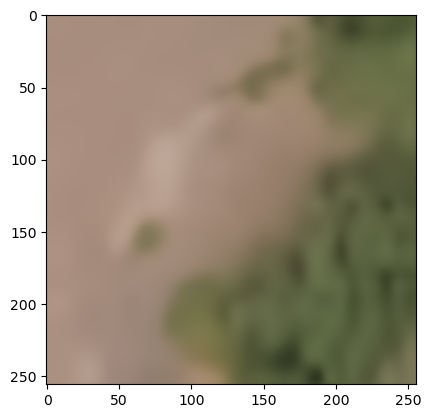

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


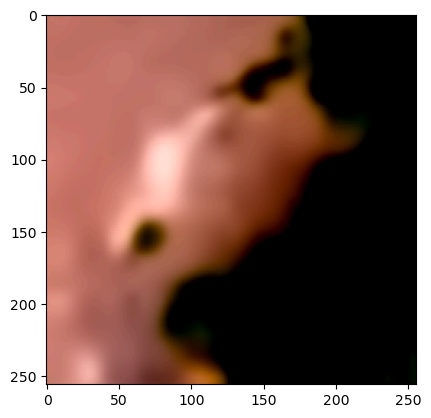

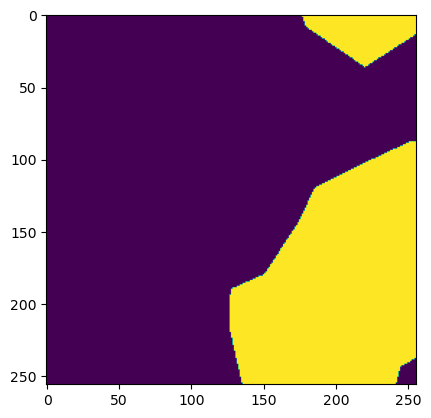

In [20]:
# Config
DATA_SPLIT = 0.90
INIT_LR = 0.005
NUM_EPOCHS = 20
BATCH_SIZE = 256
INPUT_IMAGE_SIZE = 256
THRESHOLD = 0.5
LOSS = LandmassLoss()

# define the path to each directory
BASE_DIR = "d:/Data/Test"
IMAGE_DIR = BASE_DIR + "/images.npy"
LABEL_DIR = BASE_DIR + "/labels.npy"

imgs = np.load(IMAGE_DIR, mmap_mode='r')

dataset = MemmapDataset(np.load(IMAGE_DIR, 'r'), np.load(LABEL_DIR, 'r'))
print(f"Dataset containing {len(dataset)} images loaded.")

# Setup the device to be used for training and evaluation
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Metal Performance Shaders (MPS) device.\n")
else:
    DEVICE = torch.device("cpu")
    print("WARNING: No GPU found. Defaulting to CPU.")

print(dataset[0][0].shape)
i=6
plt.imshow(imgs[i].T)
plt.show()
plt.imshow(dataset[i][0].T)
plt.show()
plt.imshow(dataset[i][1].T)
plt.show()

# Training Pipeline

In [25]:
# Training Functions
def train(model, dataset: MemmapDataset, model_name, BATCH_SIZE, save_model_every_x_epochs = 5):
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()

    opt = Adam(model.parameters(), lr=INIT_LR)
    print("[INFO] training the network...")
    training_loss = []
    all_metrics = []

    train_ds, valid_ds = dataset.split(DATA_SPLIT)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

    for epoch in tqdm(range(NUM_EPOCHS)):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}:")
        model.train()
        total_train_loss = 0
        
        for batch_idx, (x, y) in enumerate(train_loader):
            print(f" Batch {batch_idx + 1}/{len(train_loader)}", end="\r")
            
            # Send the input to the device
            x = x.to(DEVICE)
            y = y.float().to(DEVICE)

            # Perform a forward pass and calculate the training loss
            pred = model(x)
            if isinstance(pred, tuple):
                pred = pred[0]
            loss = LOSS(pred, y)

            # Zero out any previously accumulated gradients, perform backpropagation, and update model parameters
            opt.zero_grad()
            loss.backward()
            opt.step()

            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        training_loss.append(avg_train_loss)

        # Evaluate on validation dataset
        metrics = evaluate(model, test_loader)
        all_metrics.append(metrics)
        avg_test_loss = metrics['Loss']

        # Print Epoch Metrics
        print(f"Epoch: {epoch + 1}/{NUM_EPOCHS}")
        print(f"Train loss: {avg_train_loss:.6f}, Test loss: {avg_test_loss:.4f}")
        print("\nValidation Metrics:")
        for k, v in metrics.items():
            if k != 'Loss':
                print(f"{k}: {v}")
        print("\n")

        if epoch + 1 % save_model_every_x_epochs == 0 or epoch == NUM_EPOCHS-1:
            # Save model in current directory
            try:
                if not os.path.exists("trained_models/"+model_name):
                    os.makedirs("trained_models/"+model_name)
                model_filename = f"trained_models/{model_name}/epoch_{epoch}.pth"
                torch.save(model.state_dict(), model_filename)
                print(f"Saved model to {model_filename}")
            except Exception as exc:
                print(f"Error saving model: {str(exc)}")

    return training_loss, all_metrics

def evaluate(model: nn.Module, dataloader: DataLoader):
    model.eval()
    total_loss = 0
    total_TP = 0
    total_FP = 0
    total_FN = 0
    total_TN = 0

    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            x = x.to(DEVICE)
            y = y.to(DEVICE).float()
            
            pred = model(x)
            if isinstance(pred, tuple):
                pred = pred[0]
            loss = LOSS(pred, y)
            total_loss += loss.item()

            pred = torch.sigmoid(pred).view(-1)
            y = y.view(-1)
            
            TP = (pred * y).sum().item()
            FP = ((1 - y) * pred).sum().item()
            FN = (y * (1 - pred)).sum().item()
            TN = ((1 - y) * (1 - pred)).sum().item()

            total_TP += TP
            total_FP += FP
            total_FN += FN
            total_TN += TN
            
            del x, y, pred, loss
            
            print(f"Batch {idx} / {len(dataloader)}", end="\r")

    avg_loss = total_loss / len(dataloader)
    precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    iou = total_TP / (total_TP + total_FP + total_FN) if (total_TP + total_FP + total_FN) > 0 else 0
    accuracy = (total_TP + total_TN) / (total_TP + total_FP + total_FN + total_TN) if (total_TP + total_FP + total_FN + total_TN) > 0 else 0
    specificity = total_TN / (total_TN + total_FP) if (total_TN + total_FP) > 0 else 0

    metrics = {
        'Loss': avg_loss,
        'Precision': precision,
        'Recall': recall,
        'f1_score': f1_score,
        'IOU': iou,
        'Accuracy': accuracy,
        'Specificity': specificity
    }

    return metrics


In [ ]:
model = ResNet_UNet(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
model.load_state_dict(torch.load("ResNet_UNet_epoch_20.pth"))
test_set = MemmapDataset(np.load("d:/Data/Validation/images.npy", 'r'), np.load("d:/Data/Validation/labels.npy", 'r'))
test_dataloader = DataLoader(test_set, BATCH_SIZE, shuffle=True)
metrics = evaluate(model, test_dataloader)
for k, v in metrics.items():
    if k != 'Loss':
        print(f"{k}: {v}")

In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 50

model = ResNet_UNet(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
training_loss, metrics = train(model, dataset, model_name="ResNet_Unet_landmass_loss", BATCH_SIZE=BATCH_SIZE, save_model_every_x_epochs=10)
valid_loss = [x['Loss'] for x in metrics]

[INFO] training the network...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:


  0%|          | 0/50 [00:16<?, ?it/s]


KeyboardInterrupt: 

In [13]:
# Plotting functions
def plot_losses(title, training_loss, validation_loss, training_time=None, y_max=0.3):
  # scale losses to fit graph
  valid_loss = [min(x,y_max) for x in validation_loss]
  train_loss = [min(x, y_max) for x in training_loss]


  plt.figure()
  plt.plot(np.arange(1, NUM_EPOCHS+1), train_loss, label="train_loss")
  plt.plot(np.arange(1, NUM_EPOCHS+1), valid_loss, label="valid_loss")
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")
  if training_time is not None:
    plt.text(0, 0.3, f"Training Time: {training_time}")

  step = y_max / 10
  yticks = np.arange(0, y_max+step, step)  # Generate ticks from 0.025 to 0.3 with step 0.025
  plt.yticks(yticks)

  xticks = np.arange(2, NUM_EPOCHS+2, 2)  # Generate ticks from 0 to num_epochs with step 2
  plt.xticks(xticks)
  
  plt.show()

def plot_loss_comparison(title, training_losses1, training_losses2, validation_losses1, validation_losses2, compare1 = "Satellite", compare2 = "ImageNet", y_max=0.3):
    # scale losses to fit graph
    valid_loss_sat = [min(x, y_max) for x in validation_losses1]
    train_loss_sat = [min(x, y_max) for x in training_losses1]
    valid_loss_img = [min(x, y_max) for x in validation_losses2]
    train_loss_img = [min(x, y_max) for x in training_losses2]
    
    plt.figure()
    plt.plot(np.arange(0, NUM_EPOCHS), train_loss_sat, label=f"Training loss {compare1}", color='orange')
    plt.plot(np.arange(0, NUM_EPOCHS), valid_loss_sat, label=f"Validation loss {compare1}", color='orange', linestyle='dashed')
    plt.plot(np.arange(0, NUM_EPOCHS), train_loss_img, label=f"Training loss {compare2}", color='teal')
    plt.plot(np.arange(0, NUM_EPOCHS), valid_loss_img, label=f"Validation loss {compare2}", color='teal', linestyle='dashed')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    
    yticks = np.arange(0.025, 0.325, 0.025)  # Generate ticks from 0.025 to 0.3 with step 0.025
    plt.yticks(yticks)
    
    xticks = np.arange(2, NUM_EPOCHS+2, 2)  # Generate ticks from 0 to num_epochs with step 2
    plt.xticks(xticks)
    
    plt.show()

def plot_metrics(title: str, metric_dict: dict, metrics: List = ['Precision', 'Recall', 'IOU']):
    plt.figure()
    for metric in metrics:
        plt.plot(np.arange(0, NUM_EPOCHS), [x[metric] for x in metric_dict], label=metric)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend(loc="lower right")

    yticks = np.arange(0.0, 1.1, 0.1)
    plt.yticks(yticks)

    xticks = np.arange(2, NUM_EPOCHS+2, 2)
    plt.xticks(xticks)
    
    plt.show()


def plot_comparison_metrics(title, metrics: List[List[dict]], titles: List[str],
                             metrics_wanted = ['Precision', 'Recall', 'IOU'], x_label='Metrics', y_label = 'Values', y_lim = 1.1, 
                             size = (10.0, 6.0), single_metric=False):
    plt.figure(figsize=size)
    
    if single_metric:
        for i in range(len(titles)):
            plt.bar(titles[i], metrics[i][-1][metrics_wanted[0]])
    else:
        extracted_metrics = []
        for i in range(len(titles)):
            metrics_add = []
            for k in metrics[i][-1]:
                if k in metrics_wanted:
                    metrics_add.append(metrics[i][-1][k])
            extracted_metrics.append(metrics_add)

        print(extracted_metrics)

        # Create bar positions
        bar_width = 0.8 / len(titles)  # Adjust bar width based on number of titles
        r = np.arange(len(metrics_wanted))
        
        for i in range(len(titles)):
            plt.bar([x + i * bar_width for x in r], extracted_metrics[i], width=bar_width, edgecolor='grey', label=titles[i])
        plt.xticks([r + bar_width * (len(titles) / 2) for r in range(len(metrics_wanted))], metrics_wanted)

        plt.legend()
    
    # Adding labels
    plt.xlabel(x_label, fontweight='bold')
    plt.ylabel(y_label, rotation=0, labelpad=len(y_label)*2)
    plt.title(title)
    
    plt.ylim(0, y_lim)
    plt.show()

# ResNet18 Backbone

In [ ]:
"""
UNet with a ResNet 18 backbone pretrained on Sentinel-2 3 channel RGB satellite imagery
Pretrained model Weights are from SSL4EO-12 dataset @ https://github.com/zhu-xlab/SSL4EO-S12
"""
resnet18_UNet = ResNet_UNet(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
resnet18_train, resnet18_metrics = train(resnet18_UNet, dataset)
resnet18_valid = [x['Loss'] for x in resnet18_metrics]

del resnet18_UNet
gc.collect()

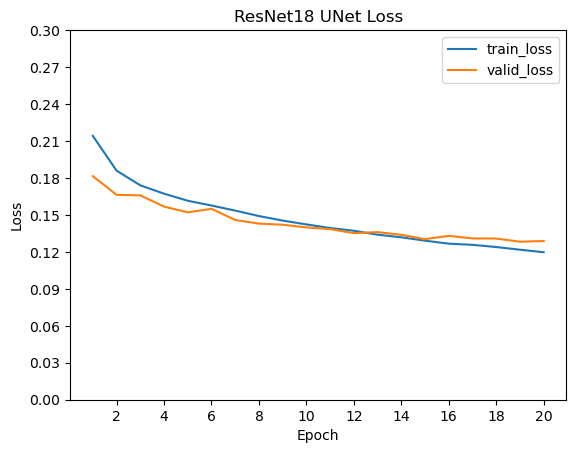

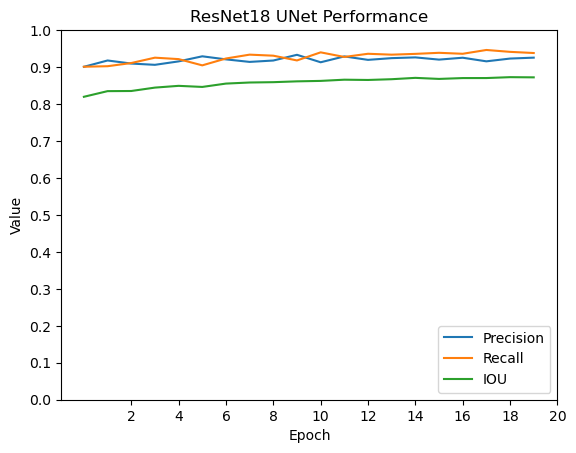

In [14]:
plot_losses("ResNet18 UNet Loss", training_loss, valid_loss)
plot_metrics("ResNet18 UNet Performance", metrics)

In [ ]:
fc18 = ResNet_FC(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
fc18_train, fc18_metrics = train(fc18, dataset)
fc18_valid = [x['Loss'] for x in fc18_metrics]

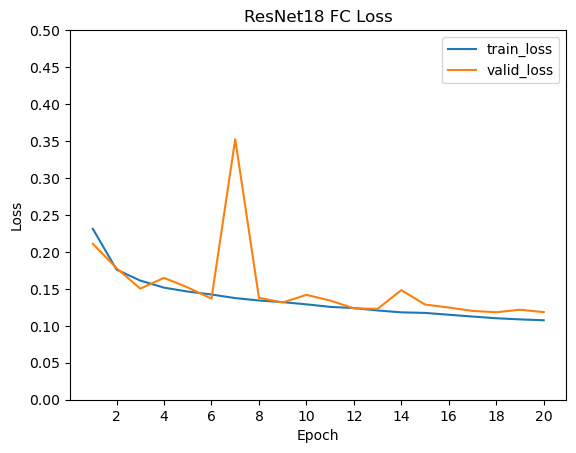

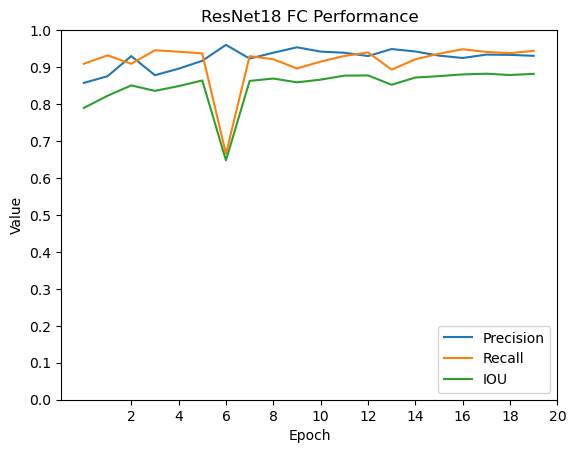

In [18]:
plot_losses("ResNet18 FC Loss", fc18_train, fc18_valid, y_max=0.5)
plot_metrics("ResNet18 FC Performance", fc18_metrics)

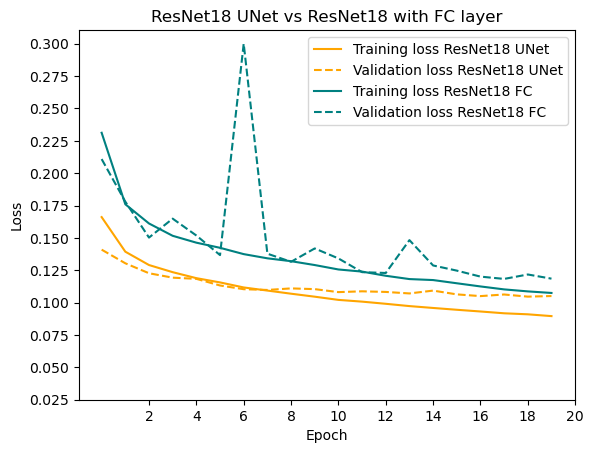

In [49]:
plot_loss_comparison("ResNet18 UNet vs ResNet18 with FC layer", resnet18_train, fc18_train, resnet18_valid, fc18_valid, compare1='ResNet18 UNet', compare2='ResNet18 FC')

We can see that the ResNet18 UNet converges with a higher performance than the ResNet18 with a fully connected layer, despite having less trainable parameters. The UNet converges around epoch 8, and we begin to see overfitting without performance gain after that.

# ResNet50 Backbone

In [ ]:
# U-Net model that uses a ResNet50 from SSL4EO-12. https://github.com/zhu-xlab/SSL4EO-S12
# The ResNet is pretrained on Sentinel-2 3-channel RGB satellite imagery

BATCH_SIZE = 128 # GPU wasn't big enough for 256
resnet50 = resnet50(weights=get_weight("ResNet50_Weights.SENTINEL2_RGB_SECO"))

resnet50 = ResNet_UNet(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
resnet50_train, resnet50_metrics = train(resnet50, dataset)
resnet50_valid = [x['Loss'] for x in resnet50_metrics]

del resnet50
gc.collect()

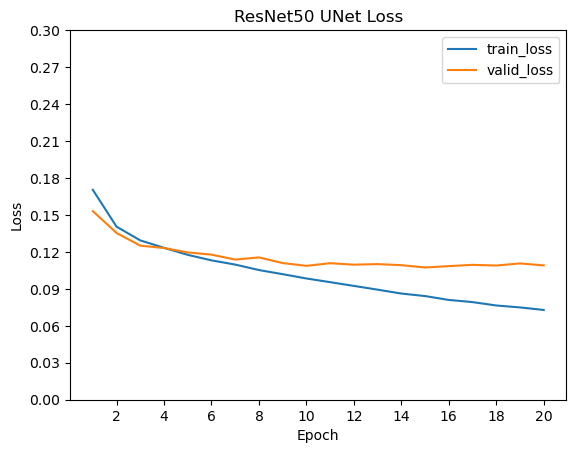

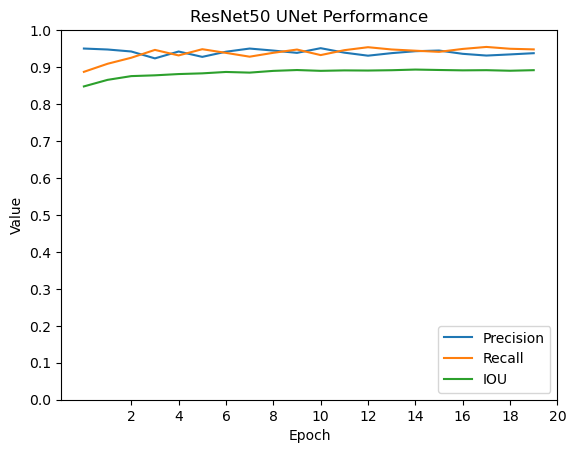

In [19]:
plot_losses("ResNet50 UNet Loss", resnet50_train, resnet50_valid)
plot_metrics("ResNet50 UNet Performance", resnet50_metrics)


In [ ]:
# ResNet50 with fully connected layer
# We are reducing the number of epochs to 10 due to overfitting seen in every model after epoch 10.
NUM_EPOCHS = 10
BATCH_SIZE = 128

fc50 = ResNet_FC(ResNet=resnet50(weights=ResNet50_Weights.DEFAULT), input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
fc50_train, fc50_metrics = train(fc50, dataset)
fc50_valid = [x['Loss'] for x in fc50_metrics]

del fc50
gc.collect()

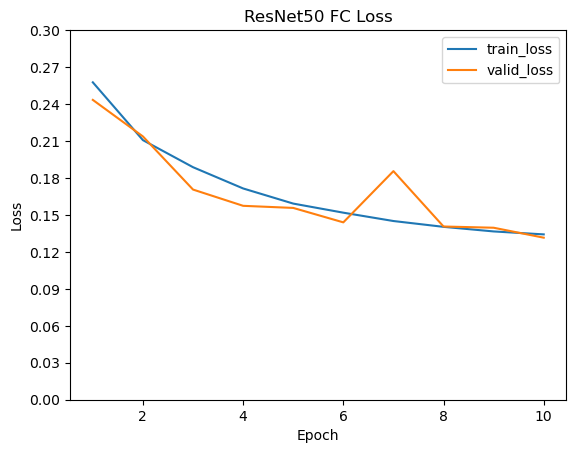

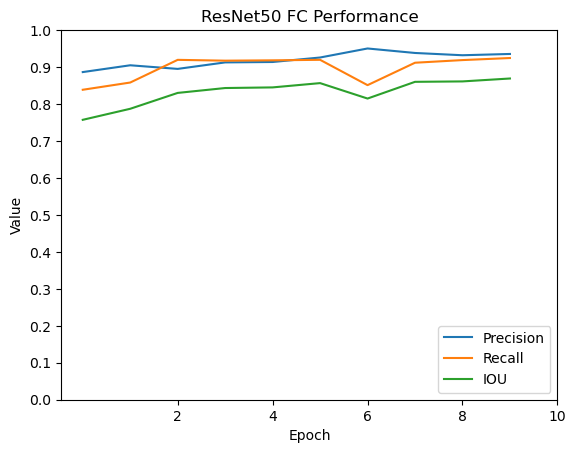

In [11]:
NUM_EPOCHS = 10
plot_losses("ResNet50 FC Loss", fc50_train, fc50_valid)
plot_metrics("ResNet50 FC Performance", fc50_metrics)

In [3]:
# Number of parameters
fc18 = ResNet_FC()
res18 = ResNet_UNet()
fc50 = ResNet_FC(ResNet=resnet50())
res50 = ResNet_UNet(ResNet=resnet50())

fc_params = sum(p.numel() for p in fc18.parameters())
res18_params = sum(p.numel() for p in res18.parameters())
fc50_params = sum(p.numel() for p in fc50.parameters())
res50_params = sum(p.numel() for p in res50.parameters())

print(f"ResNet18 with FC layer: {fc_params}\nResNet18 UNet: {res18_params}\nResNet50 with FC layer: {fc50_params}\nResNet50 UNet: {res50_params}")

ResNet18 with FC layer: 19581504
ResNet18 UNet: 15907914
ResNet50 with FC layer: 57078848
ResNet50 UNet: 99179594


# Results

[[0.9304, 0.9439, 0.8817], [0.939, 0.9505, 0.895], [0.9354, 0.9245, 0.8691], [0.9449, 0.9378, 0.8892]]


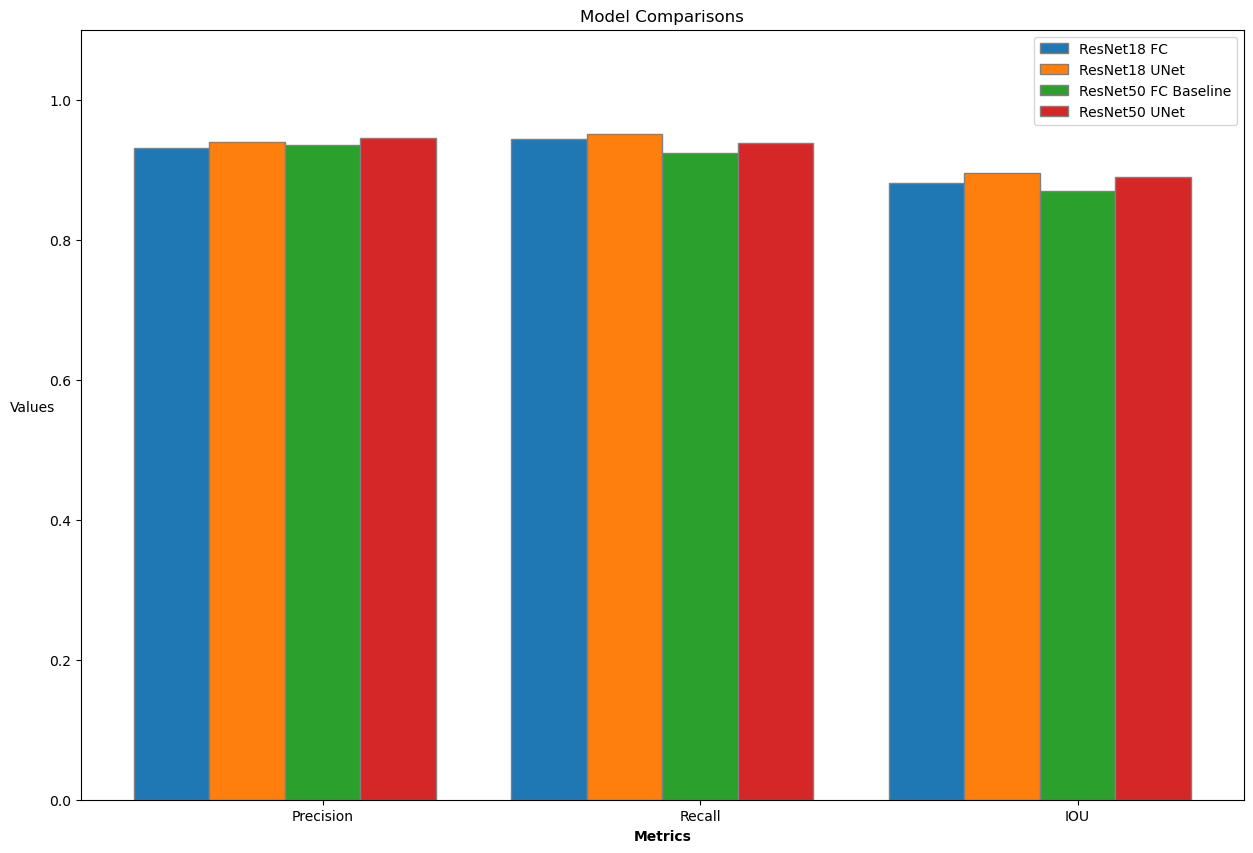

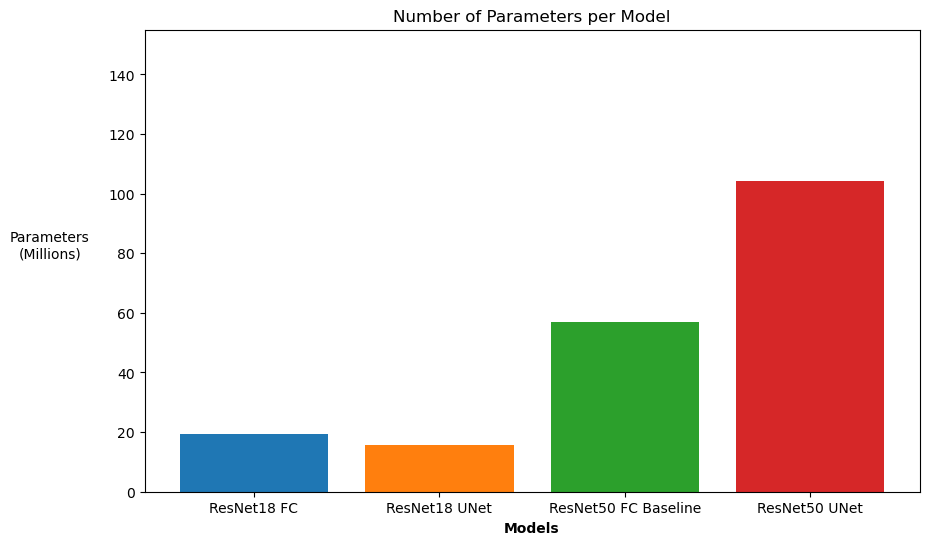

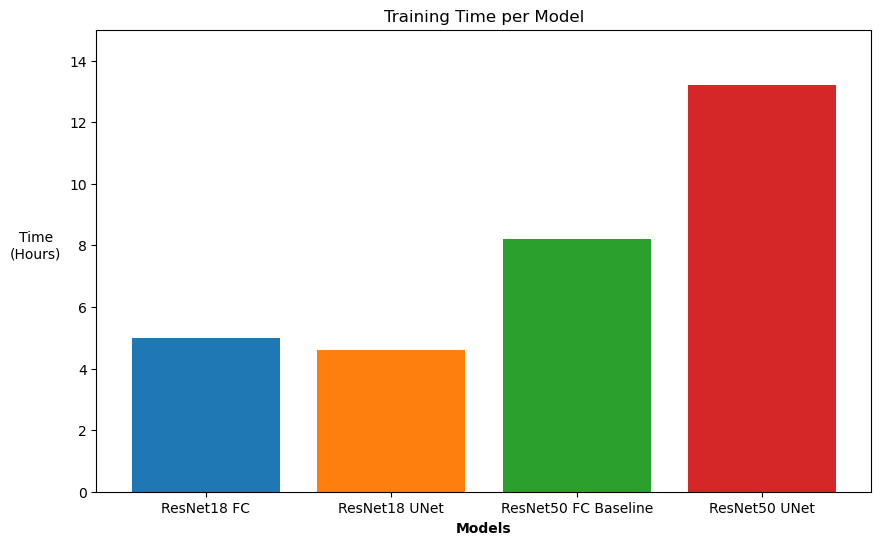

In [15]:
"""
ResNet18 UNet:
Epoch: 20/20
Train loss: 0.089591, Test loss: 0.1051

Validation Metrics:
Precision: 0.9390358130068557
Recall: 0.9505441267141128
f1_score: 0.9447549246947305
IOU: 0.8952943224316158
Accuracy: 0.9626174812789461
Specificity: 0.9687343658266366


ResNet18 FC:
Epoch: 20/20
Train loss: 0.107484, Test loss: 0.1185

Validation Metrics:
Precision: 0.9304596370170144
Recall: 0.943913300441753
f1_score: 0.9371381856326934
IOU: 0.8817121595346303
Accuracy: 0.9574169018041074
Specificity: 0.9642584113910695


ResNet50 UNet:
Epoch: 20/20
Train loss: 0.072857, Test loss: 0.1090

Validation Metrics:
Precision: 0.9375810742343926
Recall: 0.9478770521637422
f1_score: 0.9427009514208111
IOU: 0.8916124087008533
Accuracy: 0.9612521733214564
Specificity: 0.9680285892887657

ResNet50 FC:

Epoch: 10/10
Train loss: 0.134199, Test loss: 0.1315

Validation Metrics:
Precision: 0.9354888824944854
Recall: 0.9245074643618123
f1_score: 0.9299657562827044
IOU: 0.8690990608412738
Accuracy: 0.9531752160877339
Specificity: 0.9676995413798664
"""


resnet_fc18 = [{'Precision':0.9304, "Recall":0.9439, "IOU":0.8817}]
resnet_18 = [{'Precision':0.939, "Recall":0.9505, "IOU":0.895}]
resnet_fc50 = [{'Precision':0.9354, "Recall":0.9245, "IOU":0.8691}]
resnet_50 = [{'Precision':0.9449, "Recall":0.9378, "IOU":0.8892}]



metrics = []
metrics.append(resnet_fc18)
metrics.append(resnet_18)
metrics.append(resnet_fc50)
metrics.append(resnet_50)

# The FC model is the architecture from the 2020 mangrove monitoring paper, 
# so it is used as a baseline. It uses a resnet50 backbone and a fully connected layer for segmentation.
titles = ['ResNet18 FC', 'ResNet18 UNet', 'ResNet50 FC Baseline', 'ResNet50 UNet']

# Time to train for 20 epochs with RTX4090 using Memory mapped 120GB dataset
# Hours
training_time = []
training_time.append([{'time' : 5}]) #18 FC
training_time.append([{'time' : 4.6}]) #18 unet
training_time.append([{'time' : 8.2}]) #50 FC
training_time.append([{'time' : 13.2}]) #50 unet


# Number of parameters the network contains
parameters = []
parameters.append([{'Params' : 19.5}]) # 18 FC
parameters.append([{'Params' : 15.7}]) # 18 unet
parameters.append([{'Params' : 57.0}]) # 50 FC
parameters.append([{'Params' : 104.1}]) # 50 unet


# plot_loss_comparison("ResNet18 UNet vs ResNet50 UNet", resnet18_train, resnet50_train, resnet18_valid, resnet50_valid, compare1='ResNet18', compare2='ResNet50')
plot_comparison_metrics("Model Comparisons", metrics, titles, size=(15.0, 10.0))
plot_comparison_metrics("Number of Parameters per Model", parameters, titles, metrics_wanted=['Params'], x_label = 'Models', y_label='Parameters\n(Millions)', y_lim=155, single_metric=True)
plot_comparison_metrics("Training Time per Model", training_time, titles, metrics_wanted=['time'], x_label = 'Models', y_label='Time\n(Hours)', y_lim=15, single_metric=True)

We begin to see significant overfitting from the ResNet50 model after epoch 7. It also performs about the same as the ResNet18 UNet. The task that the model is performing is relatively simple, so quick convergence and overfitting is expected from a larger model with many trainable parameters. As such, single region mangrove classification is preferably done with a small model trained for few epochs. The number of epochs should scale inversely with the amount of training data. When testing with a 2GB dataset, we did not see convergence until about epoch 30.

Based on our results, the ideal model should be a ResNet18 UNet trained for 10 epochs on our 120GB dataset. It is possible that we could get similar performance from an even smaller model if a more efficient representation becomes necessary.

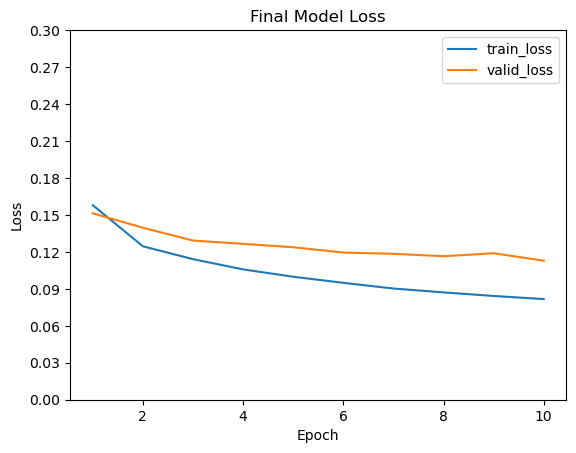

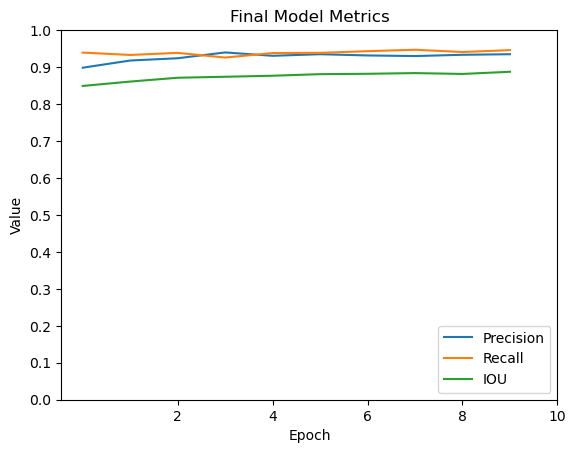

'\n\n'

In [13]:
plot_losses("Final Model Loss", training_loss, valid_loss)
plot_metrics("Final Model Metrics", metrics)

"""
Epoch 10/10:
 Batch 1570/1570
100%|██████████| 10/10 [2:27:09<00:00, 889.19s/it]
Epoch: 10/10
Train loss: 0.081702, Test loss: 0.1129

Validation Metrics:
Precision: 0.9347935675842424
Recall: 0.9458884673256911
f1_score: 0.9403082908169738
IOU: 0.8873413679360656
Accuracy: 0.9592193525674622
Specificity: 0.9660738932629552
"""